In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def preprocess_fair_scheduler_log(input_csv):
    """
    Reads FairScheduler_task_log.csv and returns a DataFrame with columns:
    step, node_id, start_time, end_time, cpu, energy
    """
    df = pd.read_csv(input_csv)
    # Extract node_id from tag (first part before '-')
    df['node_id'] = df['tag'].apply(lambda x: x.split('-')[0])
    # Identify metric type
    df['metric'] = df['tag'].apply(lambda x: 'energy' if 'energy' in x else ('cpu' if 'cpu' in x else None))
    # Only keep rows with energy or cpu
    df = df[df['metric'].notnull()]
    # Pivot so each (step, node_id) has columns for cpu and energy
    pivot = df.pivot_table(index=['step', 'node_id'], columns='metric', values='value', aggfunc='first').reset_index()
    # Add start_time and end_time columns (empty for now)
    pivot['start_time'] = ''
    pivot['end_time'] = ''
    # Reorder columns
    pivot = pivot[['step', 'node_id', 'start_time', 'end_time', 'cpu', 'energy']]
    print(f"[INFO] Preprocessed DataFrame created from {input_csv}")
    return pivot

In [27]:
filename1 = '../../../FairShareScheduler_task_log.csv'
filename2 = '../../../WaggleScheduler_task_log.csv'

In [24]:
df = preprocess_fair_scheduler_log(filename)

[INFO] Preprocessed DataFrame created from ../../../FairShareScheduler_task_log.csv


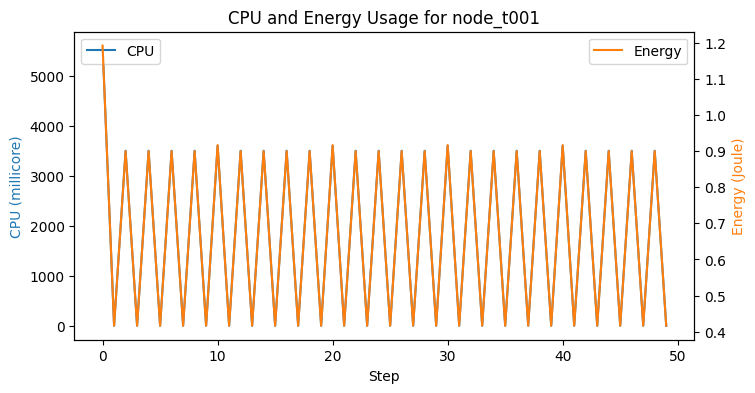

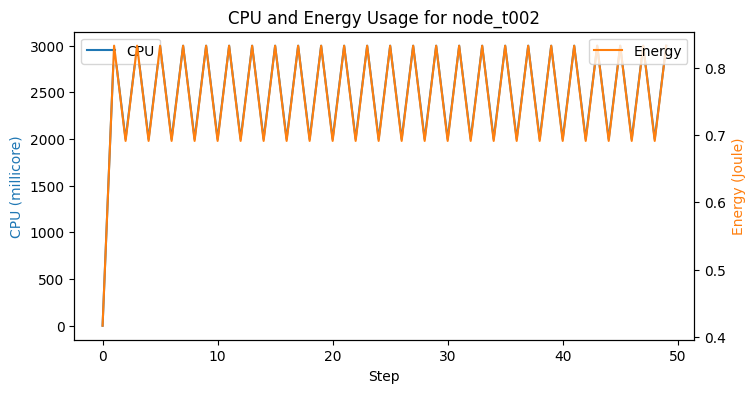

In [25]:
for node, group in df.groupby("node_id"):
    fig, ax1 = plt.subplots(figsize=(8, 4))
    ax2 = ax1.twinx()
    ax1.plot(group["step"], group["cpu"], color="tab:blue", label="CPU")
    ax2.plot(group["step"], group["energy"], color="tab:orange", label="Energy")
    ax1.set_xlabel("Step")
    ax1.set_ylabel("CPU (millicore)", color="tab:blue")
    ax2.set_ylabel("Energy (Joule)", color="tab:orange")
    plt.title(f"CPU and Energy Usage for {node}")
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")
    plt.show()

In [26]:
print("CPU statistics:")
for node, group in df.groupby("node_id"):
    print(f"\nStatistics for {node}:")
    print(group["cpu"].describe())
print(group["cpu"].describe())

CPU statistics:

Statistics for node_t001:
count      50.000000
mean     1800.000000
std      1841.693985
min         0.000000
25%         0.000000
50%      1750.000000
75%      3500.000000
max      5600.000000
Name: cpu, dtype: float64

Statistics for node_t002:
count      50.000000
mean     2460.000000
std       613.121821
min         0.000000
25%      2000.000000
50%      2500.000000
75%      3000.000000
max      3000.000000
Name: cpu, dtype: float64
count      50.000000
mean     2460.000000
std       613.121821
min         0.000000
25%      2000.000000
50%      2500.000000
75%      3000.000000
max      3000.000000
Name: cpu, dtype: float64


In [28]:
df1 = preprocess_fair_scheduler_log(filename1)
df2 = preprocess_fair_scheduler_log(filename2)

print("CPU Statistics Comparison (mean, std, min, 25%, 50%, 75%, max):\n")
for node in sorted(set(df1['node_id']).union(df2['node_id'])):
    stats1 = df1[df1['node_id'] == node]['cpu'].describe()
    stats2 = df2[df2['node_id'] == node]['cpu'].describe()
    print(f"\nNode: {node}")
    print(f"{'Stat':<8} | {'FairShare':>10} | {'Waggle':>10}")
    print("-" * 34)
    for stat in ['mean', 'std', 'min', '25%', '50%', '75%', 'max']:
        val1 = stats1.get(stat, float('nan'))
        val2 = stats2.get(stat, float('nan'))
        print(f"{stat:<8} | {val1:10.5f} | {val2:10.5f}")

[INFO] Preprocessed DataFrame created from ../../../FairShareScheduler_task_log.csv
[INFO] Preprocessed DataFrame created from ../../../WaggleScheduler_task_log.csv
CPU Statistics Comparison (mean, std, min, 25%, 50%, 75%, max):


Node: node_t001
Stat     |  FairShare |     Waggle
----------------------------------
mean     | 1800.00000 | 2310.00000
std      | 1841.69399 |  356.99997
min      |    0.00000 | 2000.00000
25%      |    0.00000 | 2000.00000
50%      | 1750.00000 | 2250.00000
75%      | 3500.00000 | 2500.00000
max      | 5600.00000 | 3100.00000

Node: node_t002
Stat     |  FairShare |     Waggle
----------------------------------
mean     | 2460.00000 | 1950.00000
std      |  613.12182 |  970.21984
min      |    0.00000 | 1000.00000
25%      | 2000.00000 | 1000.00000
50%      | 2500.00000 | 1750.00000
75%      | 3000.00000 | 3000.00000
max      | 3000.00000 | 3000.00000
